In [1]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import numpy as np
import torch

In [2]:
from bmadx import PI, M_ELECTRON, C_LIGHT
from bmadx.bmad_torch.track_torch import Beam
from bmadx.bmad_torch.track_torch import TorchDrift, TorchQuadrupole, TorchCrabCavity, TorchRFCavity, TorchSBend, TorchLattice

In [3]:
def create_6d_diagnostic_beamline():
    # Design momentum
    p_design = 10.0e6 # eV/c
    
    # Quadrupole parameters
    l_q = 1e-3
    k1 = 0.0 # scan parameter
    
    # Drift from Quad to TDC
    l_d1 = 0.165 + 0.105 + 0.165 + 0.3275 - 0.23/2
    
    # transverse deflecting cavity (TDC) parameters
    l_tdc = 0.23
    k_tdc = 2.00 # m^-1
    f_tdc = 1.3e9
    v_tdc = p_design * k_tdc * C_LIGHT / ( 2 * PI * f_tdc )
    phi_tdc = 0.0 #scan parameter (maybe?)
    
    # Drift from TDC to Bend
    l_d2 = 0.633 - 0.23/2
     
    # Bend parameters
    l_bend = 0.365 # arc length
    theta = 20.0 * PI / 180.0 # angle
    g = theta/l_bend # curvature function. positive bends in the -x direction. 
    
    # Drift from Bend to YAG
    l_d3 = 0.895
    
    # Elements:
    q = TorchQuadrupole(L = torch.tensor(l_q),
                        K1 = torch.tensor(k1),
                        NUM_STEPS = 5)
    
    d1 = TorchDrift(L = torch.tensor(l_d1))
    
    tdc = TorchCrabCavity(L = torch.tensor(l_tdc),
                          VOLTAGE = torch.tensor(v_tdc),
                          RF_FREQUENCY = torch.tensor(f_tdc),
                          PHI0 = torch.tensor(phi_tdc),
                          TILT=torch.tensor(PI/2),
                         )
    
    d2 = TorchDrift(L = torch.tensor(l_d2))
    
    bend = TorchSBend(L = torch.tensor(l_bend),
                      P0C = torch.tensor(p_design),
                      G = torch.tensor(g),
                      E1 = torch.tensor(theta/2),
                      E2 = torch.tensor(theta/2)
                     )
    
    d3 = TorchDrift(L = torch.tensor(l_d3))
    
    lattice = TorchLattice([q, d1, tdc, d2, bend, d3])
    
    return lattice

In [4]:
from generate_test_beam import generate_test_beam

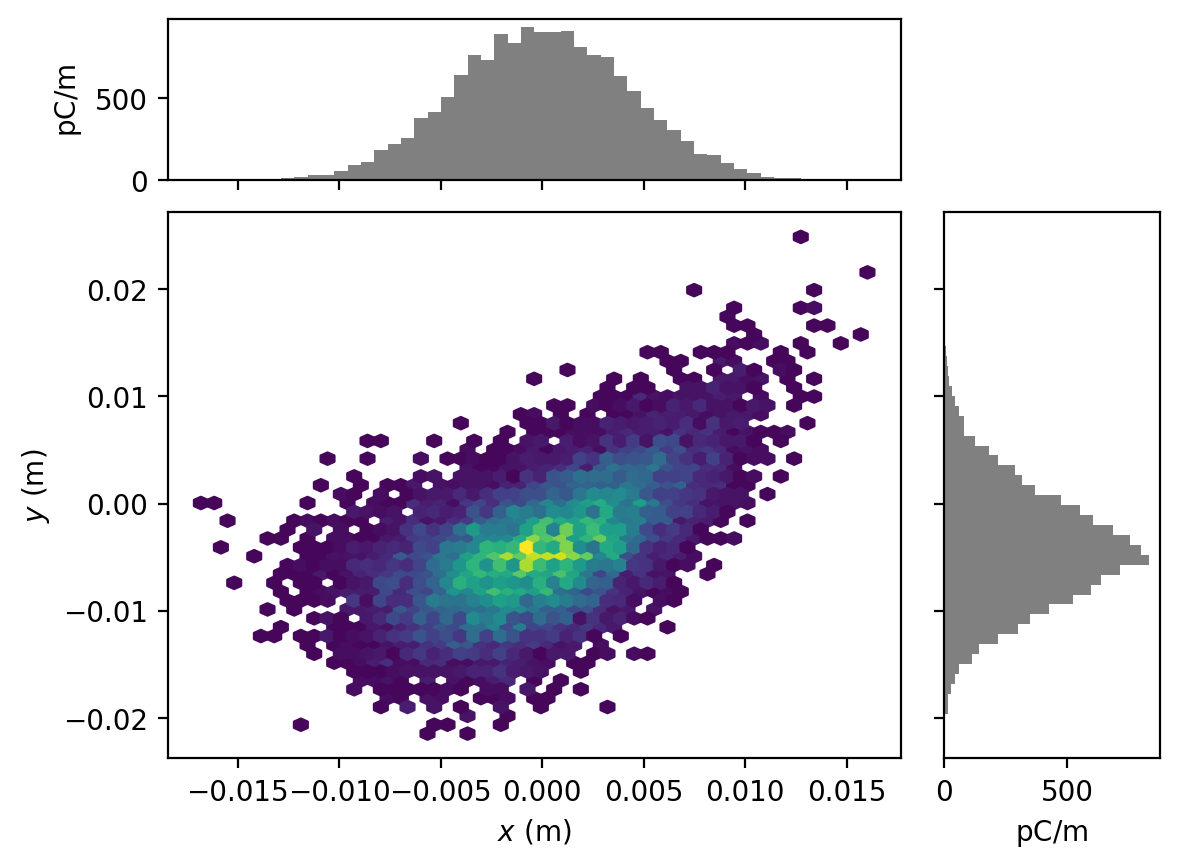

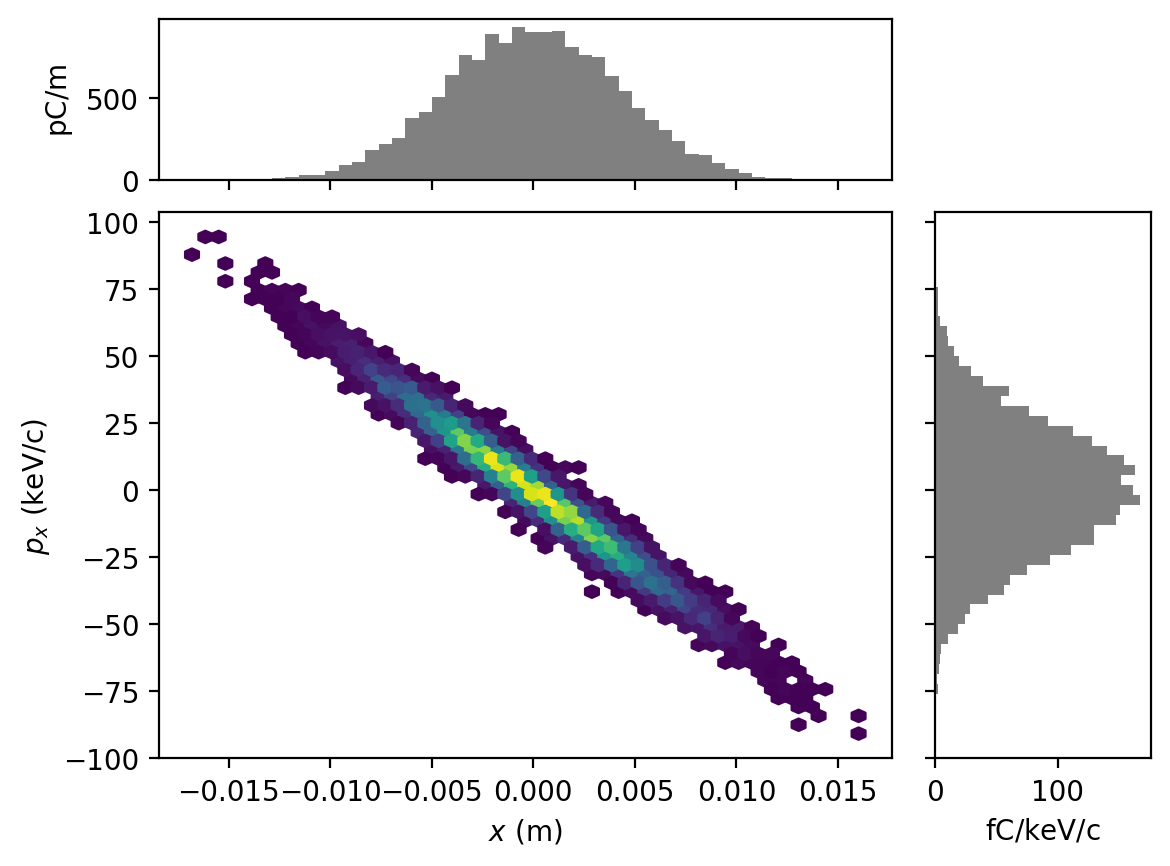

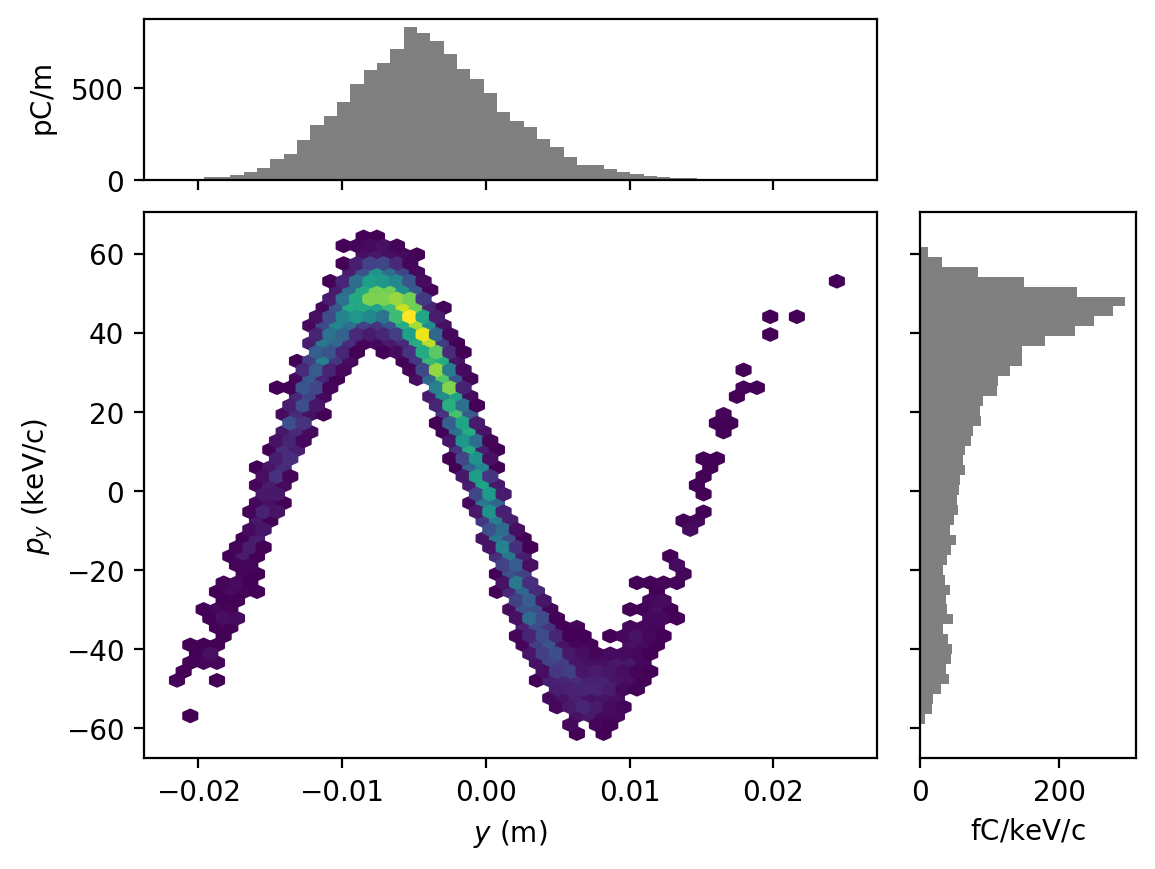

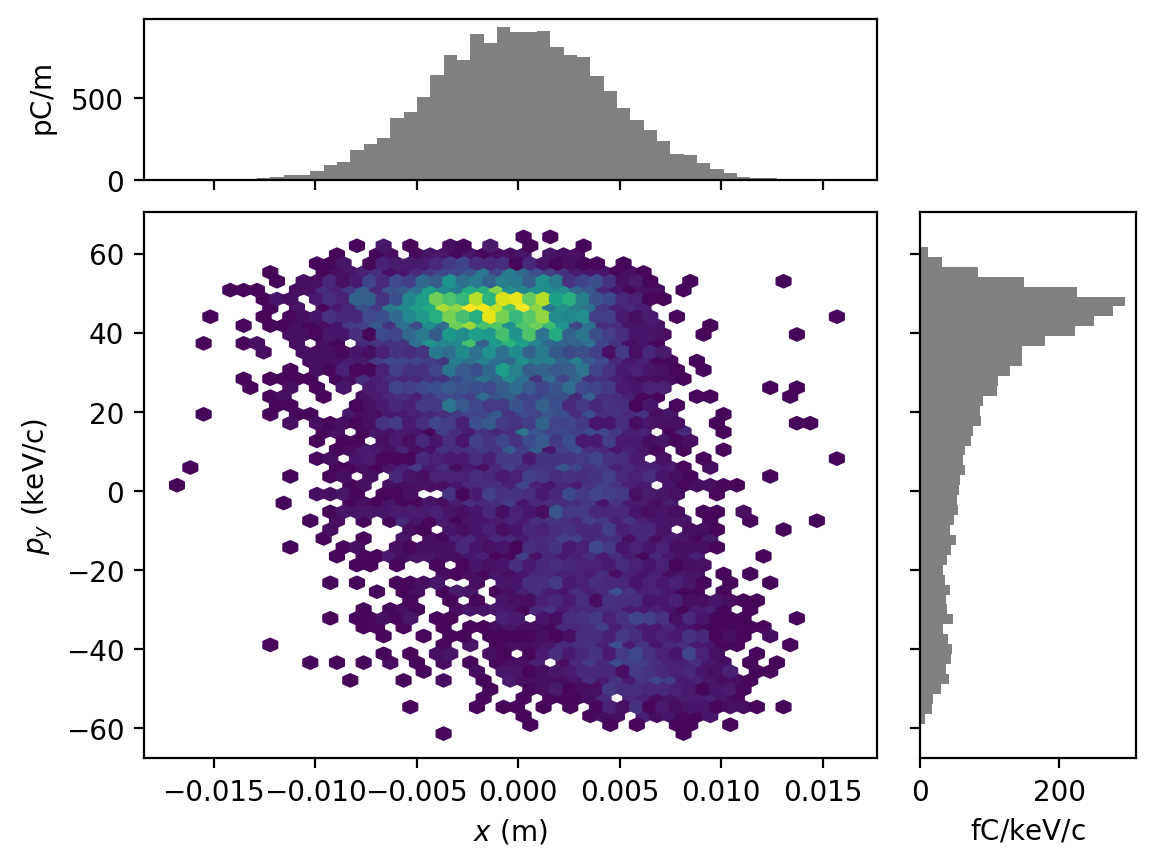

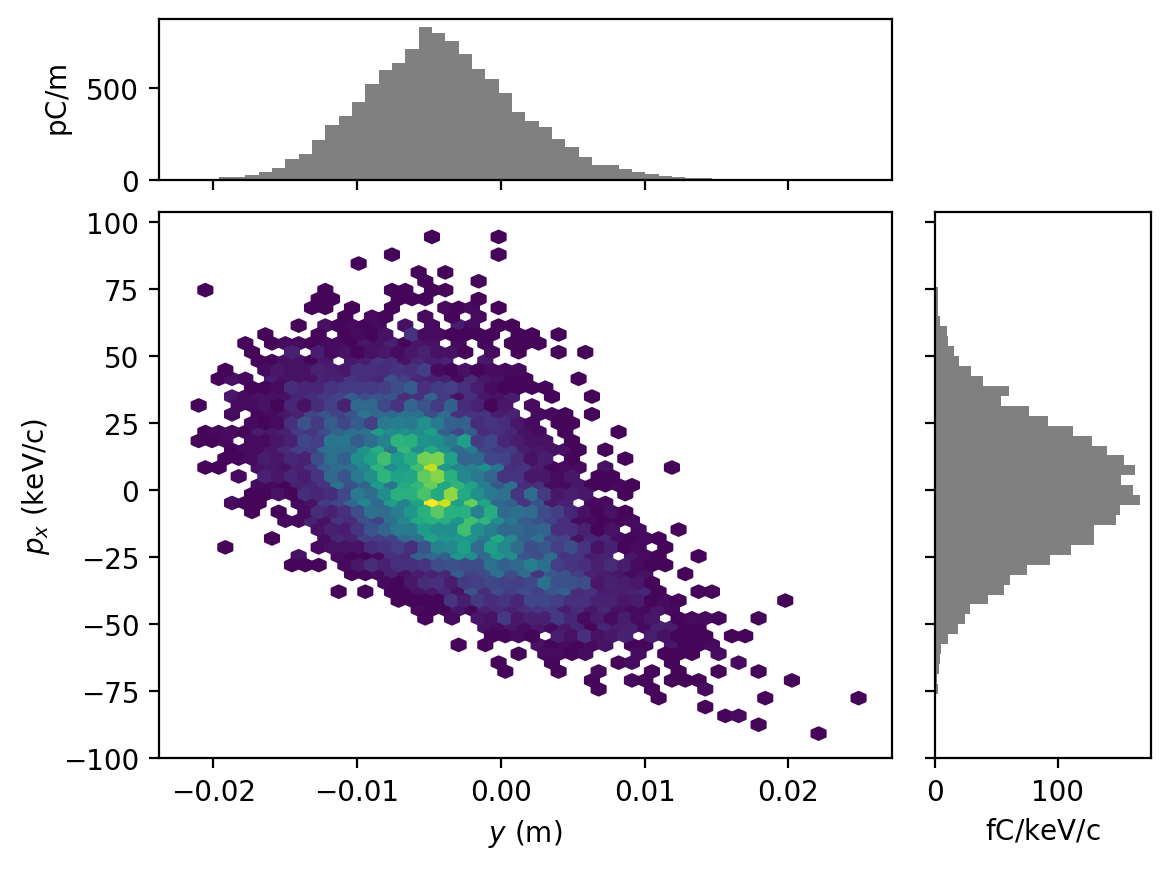

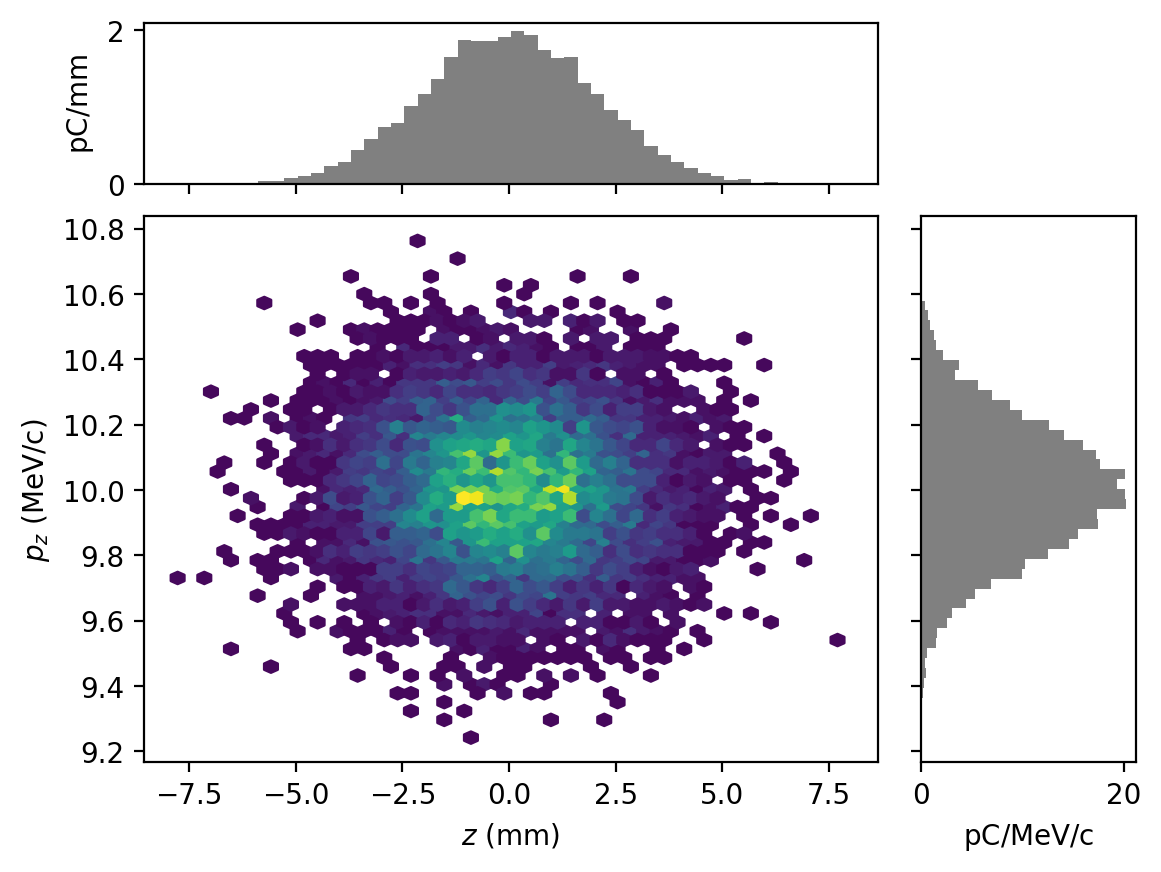

In [5]:
generate_test_beam()

In [6]:
beam_coords = torch.load("ground_truth_dist.pt")

In [7]:
input_beam = Beam(
    beam_coords,
    s=torch.tensor(0.0),
    p0c=torch.mean(beam_coords[:, -1]),
    mc2=torch.tensor(M_ELECTRON),
)

In [8]:
input_beam.p0c

Parameter containing:
tensor(-2.3450e-16, dtype=torch.float64)

In [9]:
input_beam = Beam(
    beam_coords,
    s=torch.tensor(0.0),
    p0c=torch.tensor(10.0e6),
    mc2=torch.tensor(M_ELECTRON)
)

In [10]:
input_beam.p0c

Parameter containing:
tensor(10000000.)

tensor(0.3491)
tensor(0.3491)
tensor(0.3491)
tensor([0.1769, 0.1743, 0.1789,  ..., 0.1712, 0.1751, 0.1797],
       dtype=torch.float64)


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.04  , -0.0392, -0.0384, -0.0376, -0.0368, -0.036 , -0.0352,
        -0.0344, -0.0336, -0.0328, -0.032 , -0.0312, -0.0304, -0.0296,
        -0.0288, -0.028 , -0.0272, -0.0264, -0.0256, -0.0248, -0.024 ,
        -0.0232, -0.0224, -0.0216, -0.0208, -0.02  , -0.0192, -0.0184,
        -0.0176, -0.0168, -0.016 , -0.0152, -0.0144, -0.0136, -0.0128,
        -0.012 , -0.0112, -0.0104, -0.0096, -0.0088, -0.008 , -0.0072,
        -0.0064, -0.0056, -0.0048, -0.004 , -0.0032, -0.0024, -0.0016,
        -0.0008,  0.    ,  0.0008,  0.0016,  0.0024,  0.0032,  0.004 ,
         0.0048,  0.0056,  0.0064,  0.0072,  0.008 ,  0.0088,  0.0096,
         0.0104,  0.0112,  0.012 ,  0.0128,  0.0136,  0.0144,  0.0152,
         0.016 ,  0.0168,  0.0176,  0.018

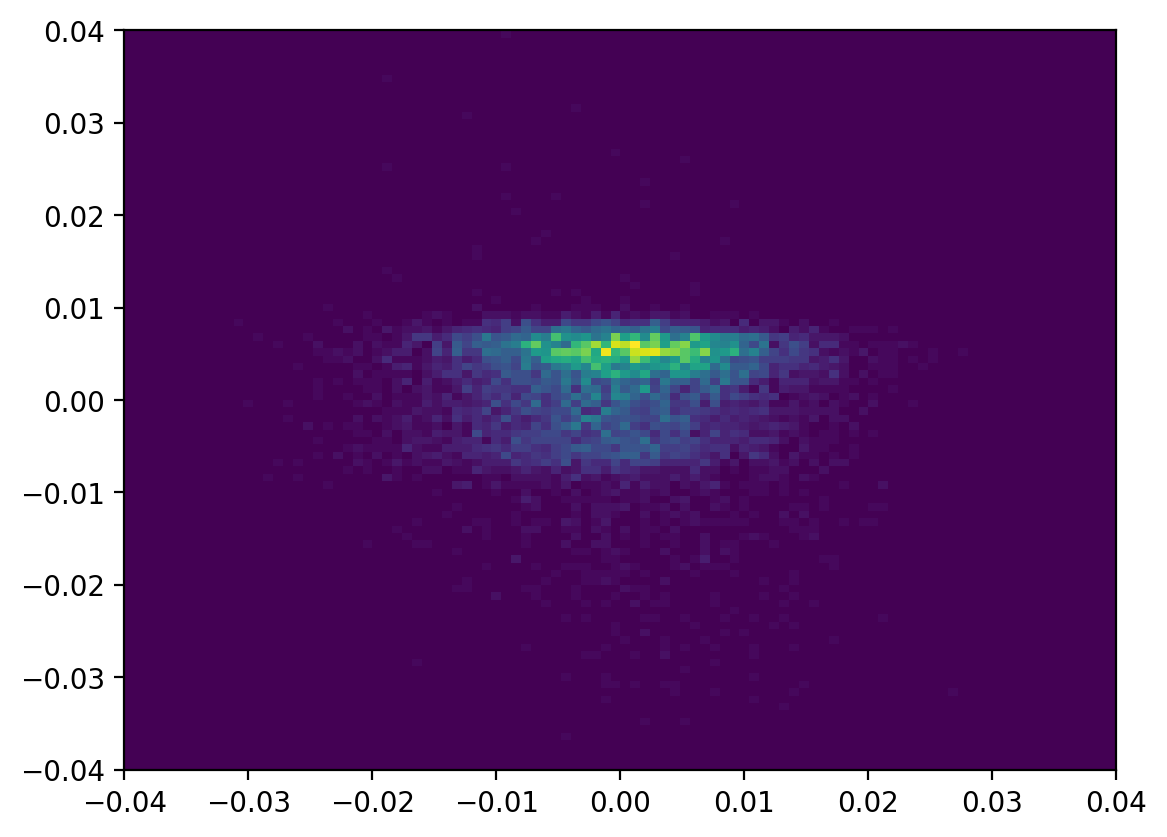

In [11]:
lattice = create_6d_diagnostic_beamline()
k_in = torch.tensor(10.0)
#bins = torch.linspace(-30, 30, 50) * 1e-3
lattice.elements[0].K1.data = k_in
lattice.elements[2].PHI0.data = torch.tensor(0)
lattice.elements[2].VOLTAGE.data = torch.tensor(0)
final_beam = lattice(input_beam)
plt.hist2d(final_beam.x.numpy(), final_beam.y.numpy(), bins=(100,100), range=[[-0.04, 0.04], [-0.04, 0.04]])

In [12]:
from generate_test_beam_2 import generate_test_beam, generate_test_images

tensor(0.3491, device='cuda:0')


/home/jp/Repositories/PS-Reconstruction/Bmad-X/bmadx/bmad/low_level/track_a_bend.py:79: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/jp/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  return sinc(x / PI)


RuntimeError: nvrtc: error: invalid value for --gpu-architecture (-arch)

  #define POS_INFINITY __int_as_float(0x7f800000)
  #define INFINITY POS_INFINITY
  #define NEG_INFINITY __int_as_float(0xff800000)
  #define NAN __int_as_float(0x7fffffff)

  typedef long long int int64_t;
  typedef unsigned int uint32_t;
  typedef signed char int8_t;
  typedef unsigned char uint8_t;  // NOTE: this MUST be "unsigned char"! "char" is equivalent to "signed char"
  typedef short int16_t;
  static_assert(sizeof(int64_t) == 8, "expected size does not match");
  static_assert(sizeof(uint32_t) == 4, "expected size does not match");
  static_assert(sizeof(int8_t) == 1, "expected size does not match");
  constexpr int num_threads = 128;
  constexpr int thread_work_size = 4; // TODO: make template substitution once we decide where those vars live
  constexpr int block_work_size = thread_work_size * num_threads;
  //TODO use _assert_fail, because assert is disabled in non-debug builds
  #define ERROR_UNSUPPORTED_CAST assert(false);

  
  
  
  namespace std {
  
  using ::signbit;
  using ::isfinite;
  using ::isinf;
  using ::isnan;
  
  using ::abs;
  
  using ::acos;
  using ::acosf;
  using ::asin;
  using ::asinf;
  using ::atan;
  using ::atanf;
  using ::atan2;
  using ::atan2f;
  using ::ceil;
  using ::ceilf;
  using ::cos;
  using ::cosf;
  using ::cosh;
  using ::coshf;
  
  using ::exp;
  using ::expf;
  
  using ::fabs;
  using ::fabsf;
  using ::floor;
  using ::floorf;
  
  using ::fmod;
  using ::fmodf;
  
  using ::frexp;
  using ::frexpf;
  using ::ldexp;
  using ::ldexpf;
  
  using ::log;
  using ::logf;
  
  using ::log10;
  using ::log10f;
  using ::modf;
  using ::modff;
  
  using ::pow;
  using ::powf;
  
  using ::sin;
  using ::sinf;
  using ::sinh;
  using ::sinhf;
  
  using ::sqrt;
  using ::sqrtf;
  using ::tan;
  using ::tanf;
  
  using ::tanh;
  using ::tanhf;
  
  using ::acosh;
  using ::acoshf;
  using ::asinh;
  using ::asinhf;
  using ::atanh;
  using ::atanhf;
  using ::cbrt;
  using ::cbrtf;
  
  using ::copysign;
  using ::copysignf;
  
  using ::erf;
  using ::erff;
  using ::erfc;
  using ::erfcf;
  using ::exp2;
  using ::exp2f;
  using ::expm1;
  using ::expm1f;
  using ::fdim;
  using ::fdimf;
  using ::fmaf;
  using ::fma;
  using ::fmax;
  using ::fmaxf;
  using ::fmin;
  using ::fminf;
  using ::hypot;
  using ::hypotf;
  using ::ilogb;
  using ::ilogbf;
  using ::lgamma;
  using ::lgammaf;
  using ::llrint;
  using ::llrintf;
  using ::llround;
  using ::llroundf;
  using ::log1p;
  using ::log1pf;
  using ::log2;
  using ::log2f;
  using ::logb;
  using ::logbf;
  using ::lrint;
  using ::lrintf;
  using ::lround;
  using ::lroundf;
  
  using ::nan;
  using ::nanf;
  
  using ::nearbyint;
  using ::nearbyintf;
  using ::nextafter;
  using ::nextafterf;
  using ::remainder;
  using ::remainderf;
  using ::remquo;
  using ::remquof;
  using ::rint;
  using ::rintf;
  using ::round;
  using ::roundf;
  using ::scalbln;
  using ::scalblnf;
  using ::scalbn;
  using ::scalbnf;
  using ::tgamma;
  using ::tgammaf;
  using ::trunc;
  using ::truncf;
  
  } // namespace std
  
  

  // NB: Order matters for this macro; it is relied upon in
  // _promoteTypesLookup and the serialization format.
  // Note, some types have ctype as void because we don't support them in codegen
  #define AT_FORALL_SCALAR_TYPES_WITH_COMPLEX(_) \
  _(uint8_t, Byte) /* 0 */                               \
  _(int8_t, Char) /* 1 */                                \
  _(int16_t, Short) /* 2 */                              \
  _(int, Int) /* 3 */                                    \
  _(int64_t, Long) /* 4 */                               \
  _(at::Half, Half) /* 5 */                                  \
  _(float, Float) /* 6 */                                \
  _(double, Double) /* 7 */                              \
  _(std::complex<at::Half>, ComplexHalf) /* 8 */        \
  _(std::complex<float>, ComplexFloat) /* 9 */                          \
  _(std::complex<double>, ComplexDouble) /* 10 */                         \
  _(bool, Bool) /* 11 */                                 \
  _(void, QInt8) /* 12 */                          \
  _(void, QUInt8) /* 13 */                        \
  _(void, QInt32) /* 14 */                        \
  _(at::BFloat16, BFloat16) /* 15 */                             \

  #define AT_FORALL_SCALAR_TYPES_WITH_COMPLEX_EXCEPT_COMPLEX_HALF(_) \
  _(uint8_t, Byte)                                                 \
  _(int8_t, Char)                                                  \
  _(int16_t, Short)                                                \
  _(int, Int)                                                      \
  _(int64_t, Long)                                                 \
  _(at::Half, Half)                                                \
  _(float, Float)                                                  \
  _(double, Double)                                                \
  _(std::complex<float>, ComplexFloat)                             \
  _(std::complex<double>, ComplexDouble)                           \
  _(bool, Bool)                                                    \
  _(at::BFloat16, BFloat16)


  enum class ScalarType : int8_t {
  #define DEFINE_ENUM(_1, n) n,
  AT_FORALL_SCALAR_TYPES_WITH_COMPLEX(DEFINE_ENUM)
  #undef DEFINE_ENUM
      Undefined,
  NumOptions
  };

  template <typename T, int size>
  struct Array {
  T data[size];

  __device__ T operator[](int i) const {
      return data[i];
  }
  __device__ T& operator[](int i) {
      return data[i];
  }
  Array() = default;
  Array(const Array&) = default;
  Array& operator=(const Array&) = default;
  };

  
  
  
  




  template <typename scalar_t>
  __device__ __inline__ scalar_t load(char* base_ptr, uint32_t offset) {
      return *(reinterpret_cast<scalar_t*>(base_ptr) + offset);
  }

  template<typename scalar_t>
  __device__ __inline__ void store(scalar_t value, char *base_ptr, uint32_t offset) {
      *(reinterpret_cast<scalar_t *>(base_ptr) + offset) = value;
  }

  // aligned vector generates vectorized load/store on CUDA
  template<typename scalar_t, int vec_size>
  struct alignas(sizeof(scalar_t) * vec_size) aligned_vector {
    scalar_t val[vec_size];
  };

  template <typename T> T sinc(T a) { if (a == T(0)) { return T(1); } else { constexpr T pi = T(3.14159265358979323846L); T product = pi * a; return std::sin(product) / product; } }

  // TODO: setup grid-stride loop

  extern "C" __global__
  void sinc_vectorized4_kernel(
      const int N,
      Array<char*, 1+1> data,
      float scalar_val) //[1+1],
      {
      constexpr int vec_size = 4;
      int remaining = N - block_work_size * blockIdx.x;
      auto thread_idx = threadIdx.x;
      int idx = blockIdx.x;
      float arg0[4];
      
      float out[4];
      

      if (remaining < block_work_size) {
        #pragma unroll
        for (int j = 0; j < thread_work_size; j++){
          if (thread_idx >= remaining) {
            break;
          }
          int linear_idx = thread_idx + block_work_size * idx;
          arg0[j] = load<float>(data[1], linear_idx);
          
          thread_idx += num_threads;
        }
        #pragma unroll
        for (int j = 0; j < thread_work_size; j++) {
          if ((threadIdx.x  + j*num_threads) < remaining) {
            out[j] = sinc<float>(arg0[j] );
          }
        }
        thread_idx = threadIdx.x;
        #pragma unroll
        for (int j = 0; j < thread_work_size; j++) {
          if (thread_idx >= remaining) {
              break;
          }
          int linear_idx = thread_idx + block_work_size * idx;
          store<float>(out[j], data[0], linear_idx);
          thread_idx += num_threads;
        }
      } else {
        static constexpr int loop_size = thread_work_size / vec_size;
  //actual loading
        using vec_t_input = aligned_vector<float, vec_size>;
        vec_t_input * vec0 = reinterpret_cast<vec_t_input *>(data[0+1]) + block_work_size / vec_size * idx;
        
        #pragma unroll
        for (int i = 0; i<loop_size; i++){
          vec_t_input v;
          v = vec0[thread_idx];
          #pragma unroll
          for (int j=0; j < vec_size; j++){
            arg0[vec_size * i + j] = v.val[j];
          }
          
          thread_idx += num_threads;
        }


        #pragma unroll
        for (int j = 0; j < thread_work_size; j++) {
          out[j] = sinc<float>(arg0[j]);
        }
        using vec_t_output = aligned_vector<float, vec_size>;
        vec_t_output * to_ = reinterpret_cast<vec_t_output *>(data[0]) + block_work_size / vec_size * idx;
        int thread_idx = threadIdx.x;
        #pragma unroll
        for (int i = 0; i<loop_size; i++){
          vec_t_output v;
          #pragma unroll
          for (int j=0; j<vec_size; j++){
            v.val[j] = out[vec_size * i + j];
          }
          to_[thread_idx] = v;
          thread_idx += num_threads;
        }
      }
  }


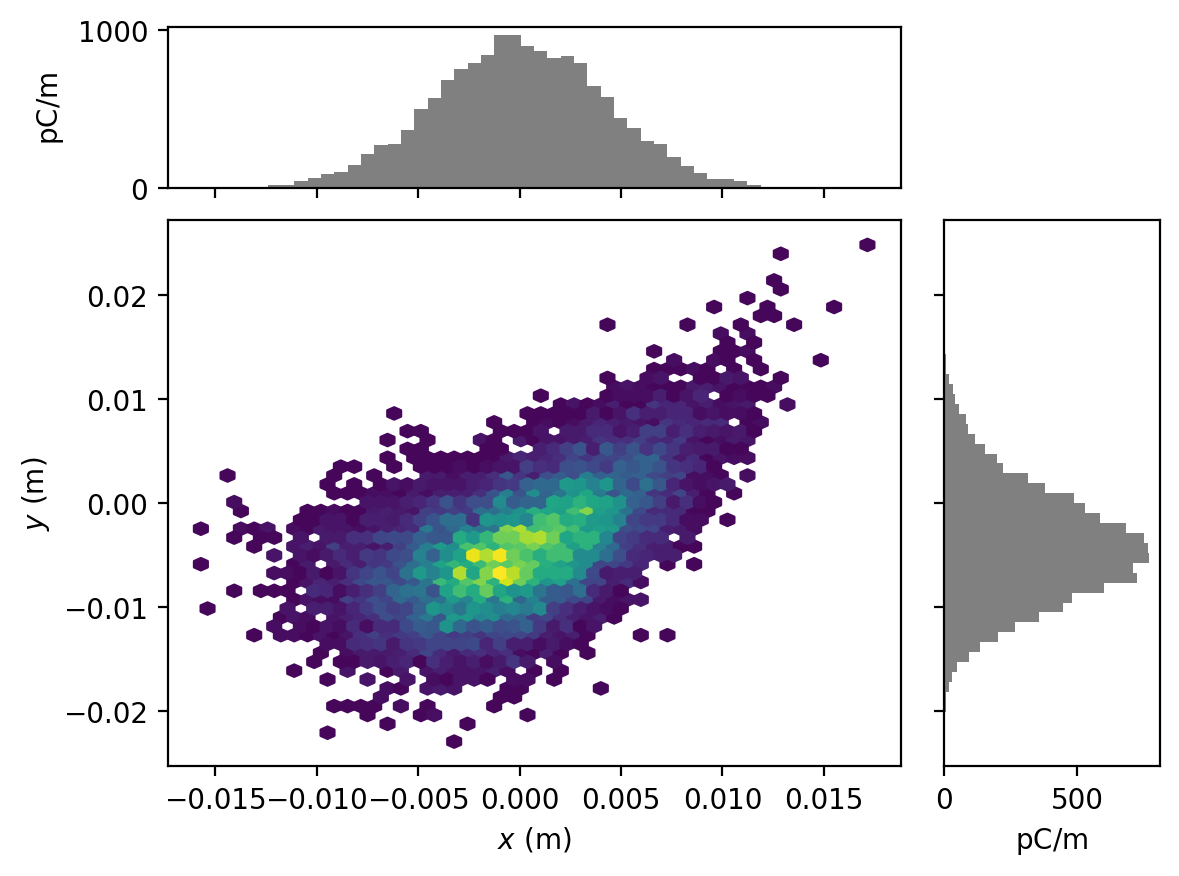

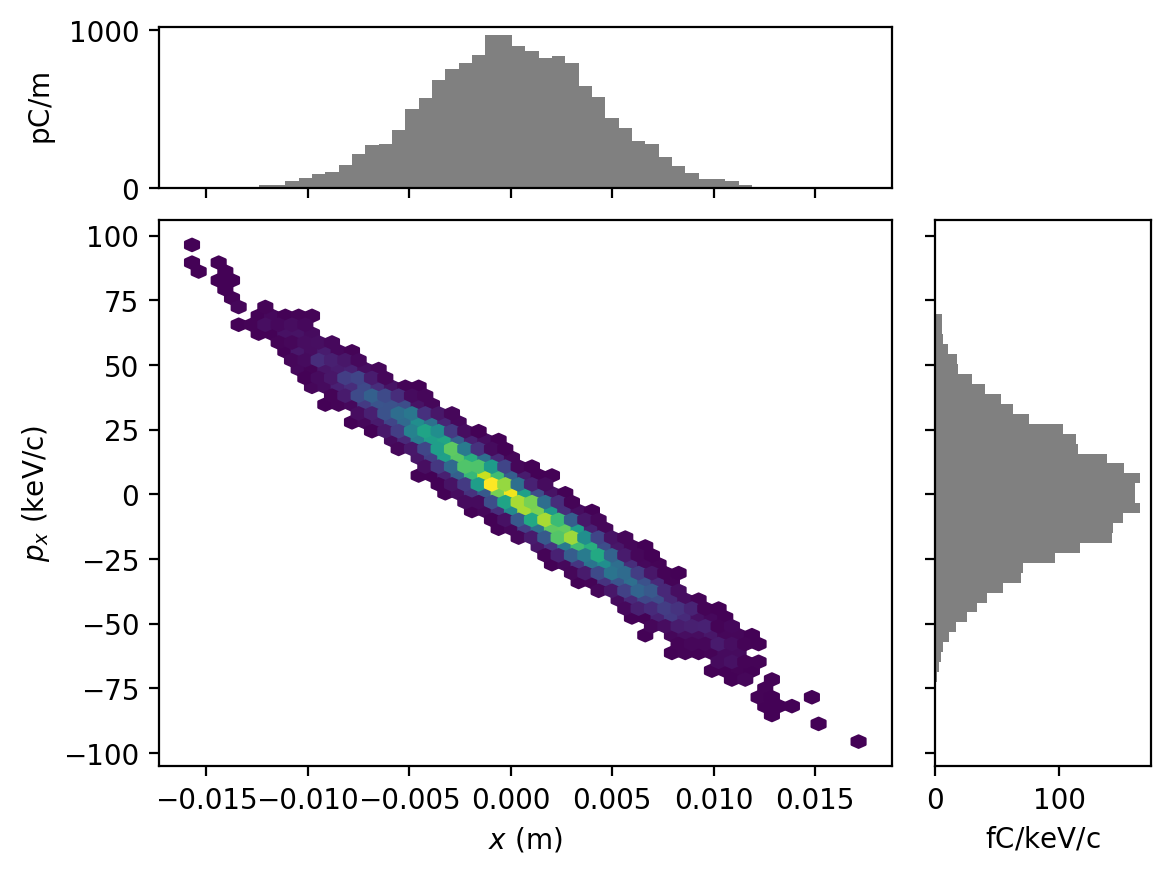

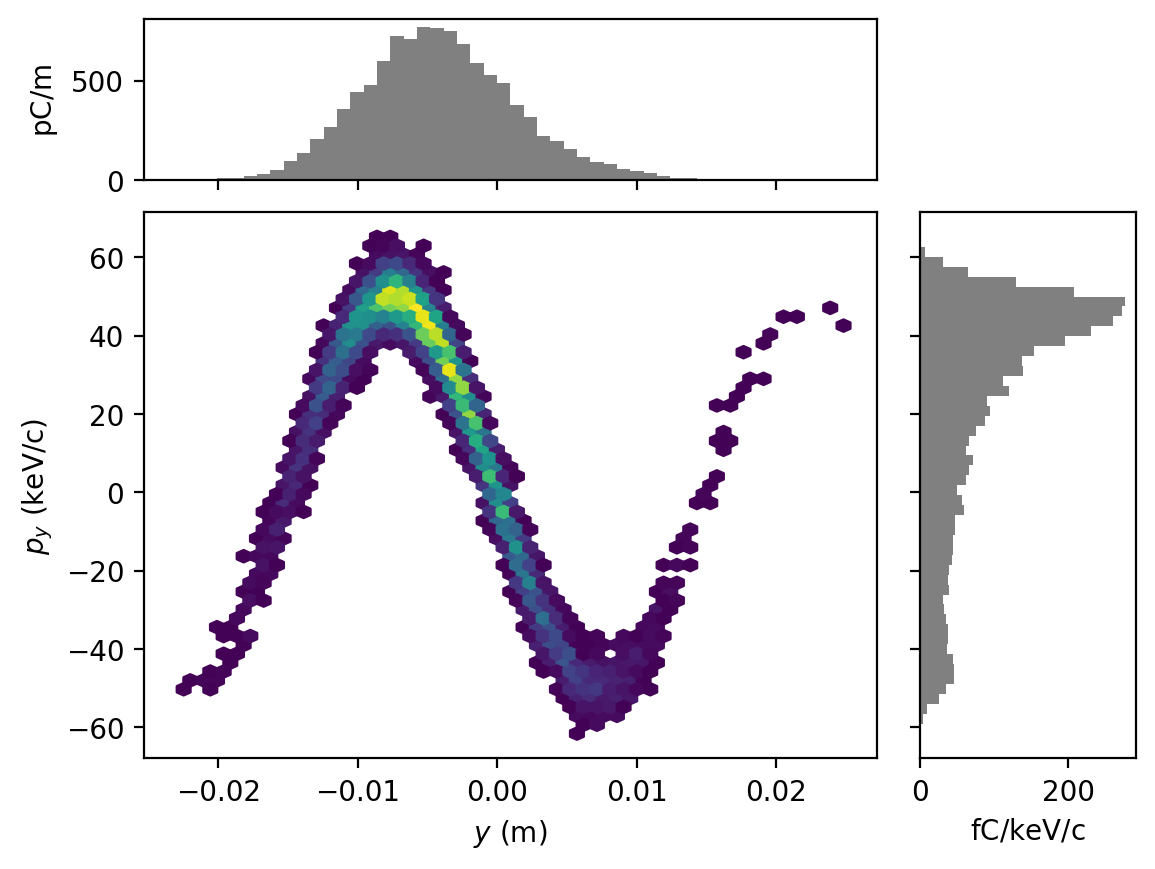

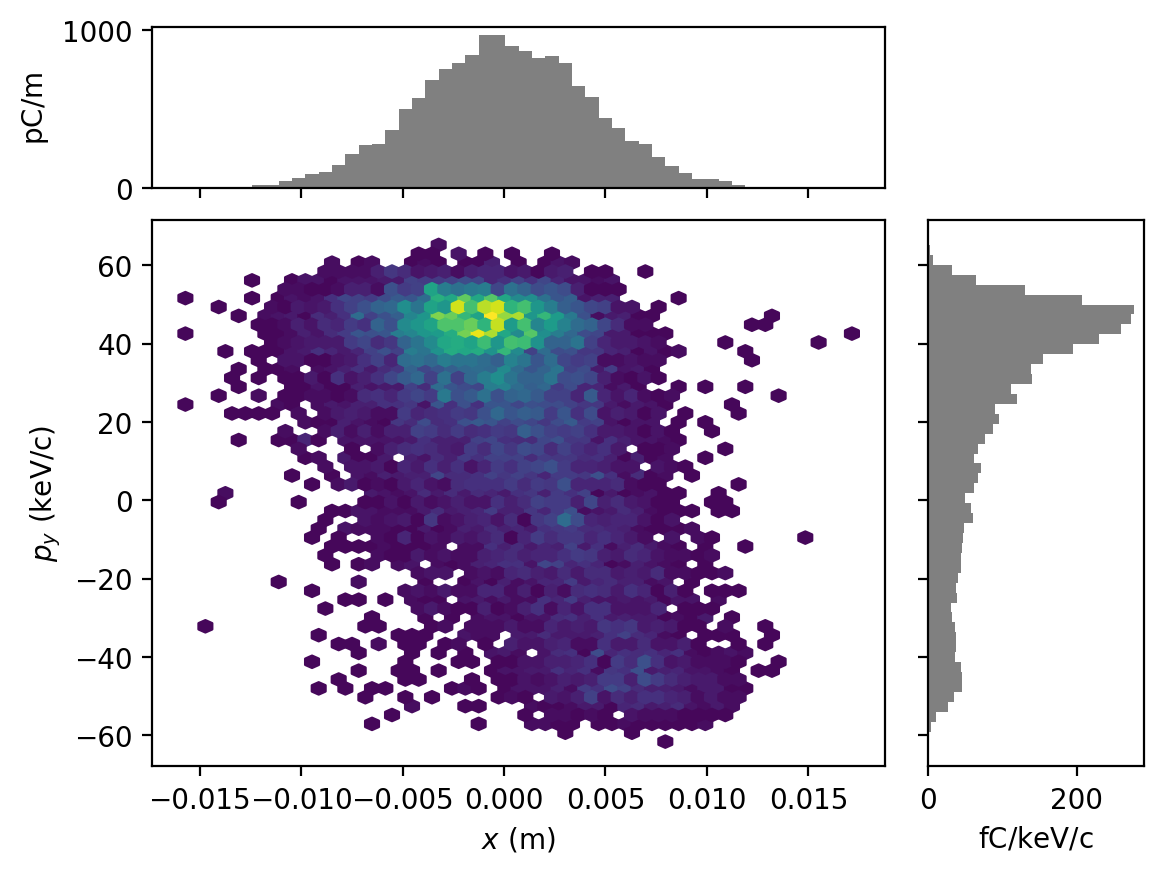

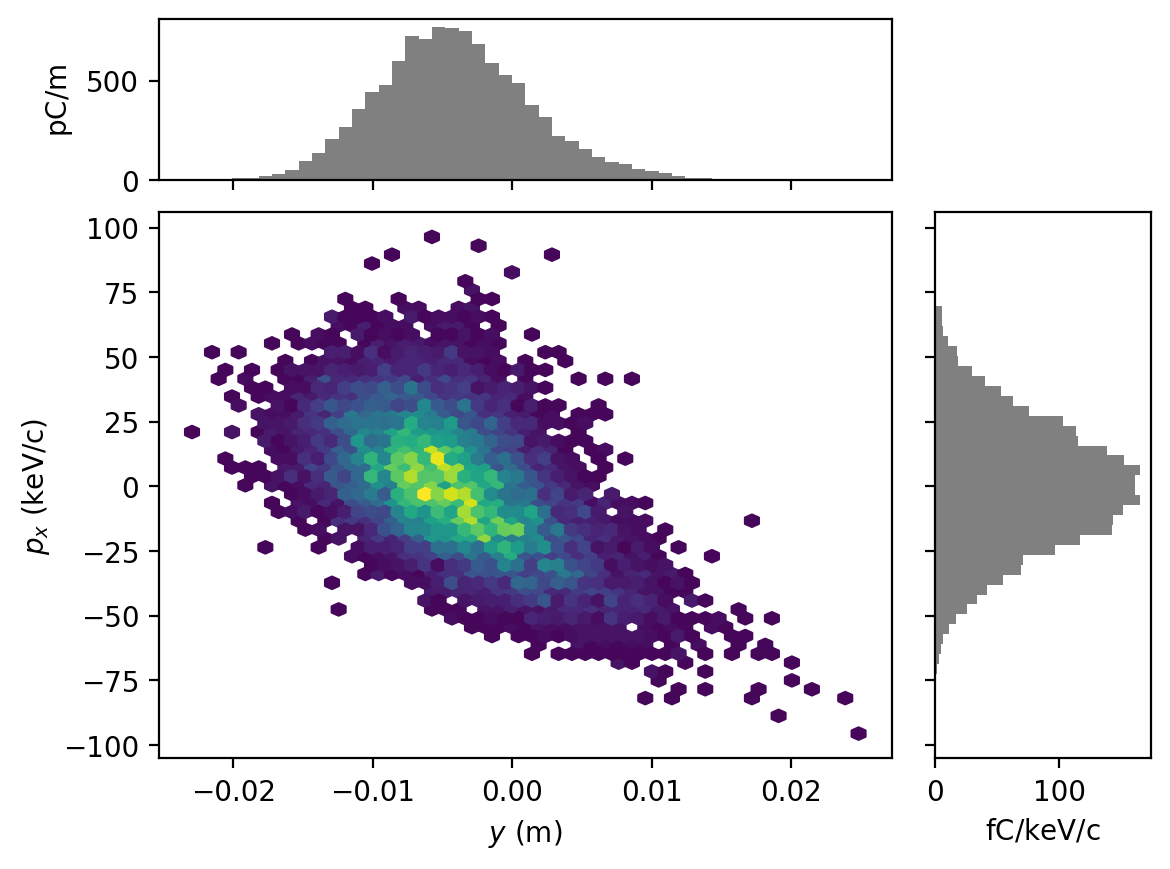

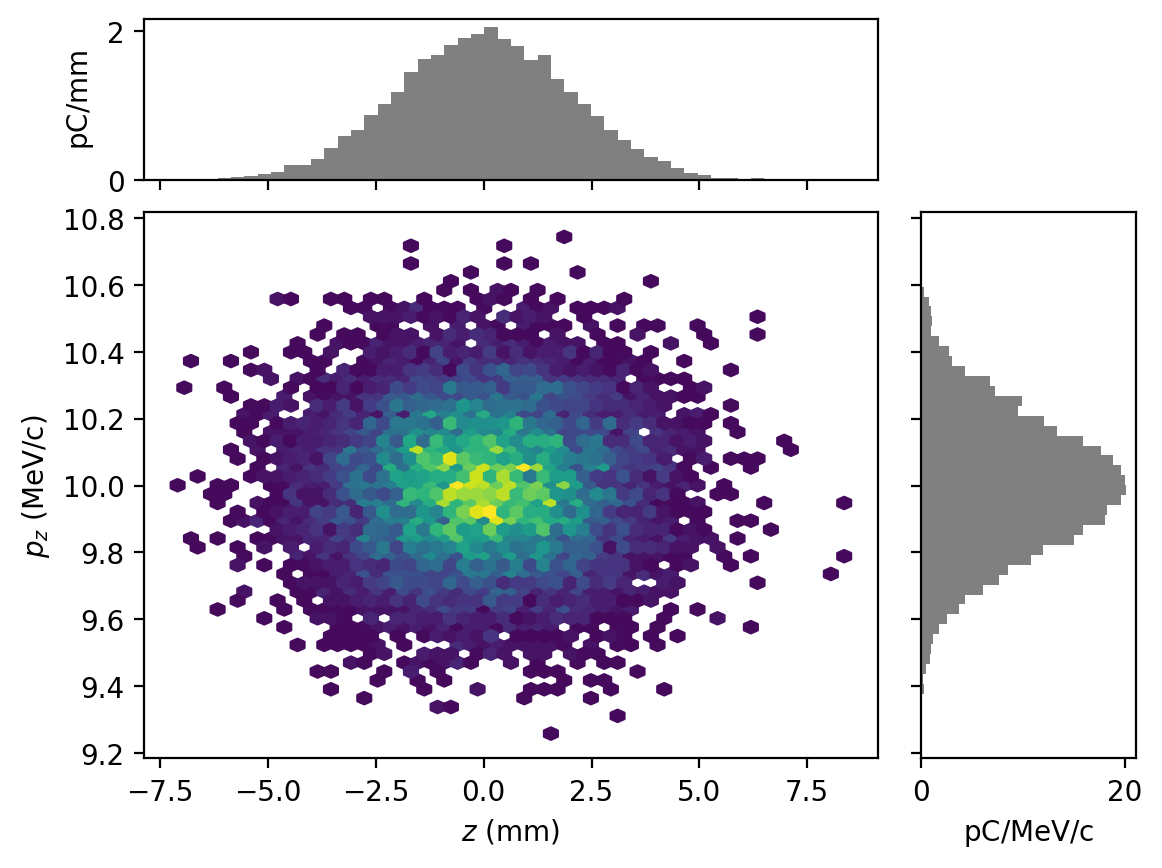

In [13]:
generate_test_images()